<a href="https://colab.research.google.com/github/IAugustoMZ/anomaly_detection/blob/main/Monitoramento_de_Qualidade_de_Processo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import os
import seaborn as sns

In [ ]:
# montando drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importando base de dados
filePath = '/content/drive/My Drive/Process Quality Control - PLS project'
fileName = 'process_data.csv'
data = pd.read_csv(os.path.join(filePath, fileName))
data.head()

,solutionA_inletFlowRate,water_inletFlowRate,solutionB_inletFlowRate,componentA_inletConcentration,componentB_inletConcentration,solutionA_inletTemperature,water_inletTemperature,solutionB_inletTemperature,componentA_outletConcentration,componentB_outletConcentration,componentC_outletConcentration,outletTemperature
0,2.488026,7.022645,0.493385,7.415100,12.313350,29.232410,10.161989,29.204568,1.747784,0.414548,0.192728,96.089927
1,2.564250,7.210281,0.521194,7.001721,12.246920,30.321235,9.813532,29.937081,1.649414,0.431103,0.188865,95.193304
2,2.578252,7.356546,0.530302,7.039666,11.964474,29.647262,9.939467,30.877037,1.648039,0.433679,0.172601,88.922935
3,2.438043,6.534329,0.492974,7.097230,12.032390,29.074167,10.126576,30.156679,1.716432,0.403386,0.223285,108.955373
4,2.222003,6.377055,0.496884,7.185610,11.724253,31.573436,10.024570,28.878612,1.637008,0.403802,0.236659,114.179174


In [ ]:
# checando informações dos dados
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   solutionA_inletFlowRate         5000 non-null   float64
 1   water_inletFlowRate             5000 non-null   float64
 2   solutionB_inletFlowRate         5000 non-null   float64
 3   componentA_inletConcentration   5000 non-null   float64
 4   componentB_inletConcentration   5000 non-null   float64
 5   solutionA_inletTemperature      5000 non-null   float64
 6   water_inletTemperature          5000 non-null   float64
 7   solutionB_inletTemperature      5000 non-null   float64
 8   componentA_outletConcentration  5000 non-null   float64
 9   componentB_outletConcentration  5000 non-null   float64
 10  componentC_outletConcentration  5000 non-null   float64
 11  outletTemperature               5000 non-null   float64
dtypes: float64(12)
memory usage: 468.9

Verifica-se qur todos os dados obtidos são da categoria númerico e que também não há valores nulos presentes.

O conjunto de dados é constituído de 11 variáveis de processo, sendo 7 delas são variáveis de controle (*input*) e as 4 restantes, variáveis de saída (*output*).

São variáveis de entrada:
- vazão de solução A
- vazão de água
- vazão de solução B
- concentração de entrada do componente A
- concentração de entrada do componente B
- temperatura de entrada da solução A
- temperatura de entrada de água
- temperatura de entrada da solução B

São variáveis de saída:
- concentração de saída do componente A
- concentração de saída do componente B
- concentração de saída do componente C
- temperatura de saída


# **Objetivo do Estudo**

No processo em estudo, estamos interessados no componente C, que é o que agrega valor. Sabendo que essa reação não é completa, deseja-se determinar qual a combinação de variáveis de entrada que possa oferecer maior concentração de componente C, levando-se em consideração o aspecto da segurança do processo.

Para tanto, alguns indicadores serão criados nessa base de dados, para expressar o desempenho do processo. Esses indicadores são conhecidos como *conversão* e *seletividade* e ambos serão calculados sobre o reagente B, que é o limitante nessa situação.

Lembrando a definição:

- *Conversão*: quanto do reagente limitante reagiu no processo, dado pela razão entre a diferença da concentração inicial e final, e a concentração inicial
- *Rendimento*: quanto foi produzido do produto de interesse sobre quanto poderia ter sido produzido, com base na massa de reagente limitante

In [ ]:
# criação das colunas de indicadores
data['X'] = (data['componentB_inletConcentration']-data['componentB_outletConcentration'])/data['componentB_inletConcentration']
data['Yield'] = (data['componentC_outletConcentration']*(data['solutionA_inletFlowRate']+data['solutionB_inletFlowRate'])+data['water_inletFlowRate'])
/(data['componentB_inletConcentration']*data['solutionB_inletFlowRate'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   solutionA_inletFlowRate         5000 non-null   float64
 1   water_inletFlowRate             5000 non-null   float64
 2   solutionB_inletFlowRate         5000 non-null   float64
 3   componentA_inletConcentration   5000 non-null   float64
 4   componentB_inletConcentration   5000 non-null   float64
 5   solutionA_inletTemperature      5000 non-null   float64
 6   water_inletTemperature          5000 non-null   float64
 7   solutionB_inletTemperature      5000 non-null   float64
 8   componentA_outletConcentration  5000 non-null   float64
 9   componentB_outletConcentration  5000 non-null   float64
 10  componentC_outletConcentration  5000 non-null   float64
 11  outletTemperature               5000 non-null   float64
 12  X                               50

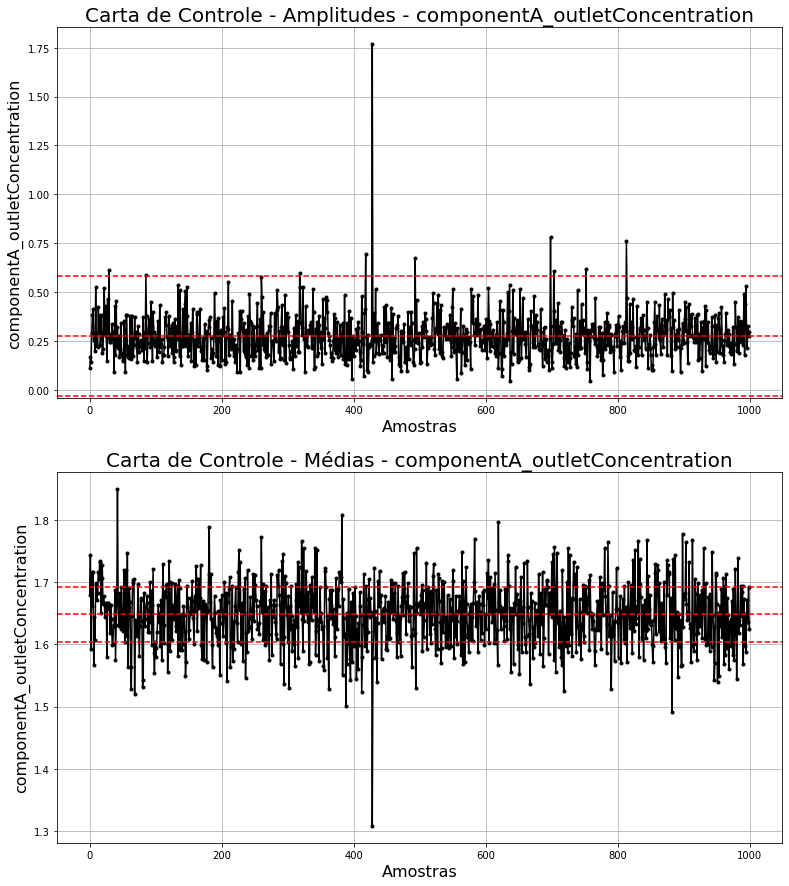

In [ ]:
# construção de cartas de controle para monitoramento das variáveis de saída
var_name = 'componentA_outletConcentration'


def control_chart(data, var_name, n = 5):
  # função que plota as cartas de controle da média e amplitudes para determinado
  # processo, com base em uma amostragem de n pontos por minuto

  to_monitor = pd.DataFrame(data[var_name], columns=[var_name])

  # definição do dicionário de valores de constantes
  d2_dict = {2: 1.128, 3: 1.693, 4: 2.059, 5: 2.326, 6: 2.534, 7: 2.704,
            8: 2.847, 9: 2.970, 10: 3.078, 11: 3.173, 12: 3.258, 13: 3.336,
            14: 3.407, 15: 3.472}
  d3_dict = {2: 0.853, 3: 0.888, 4: 0.880, 5: 0.864, 6: 0.848, 7: 0.833,
            8: 0.820, 9: 0.808, 10: 0.797, 11: 0.787, 12: 0.778, 13: 0.770,
            14: 0.763, 15: 0.756}

  # agrupamento dos monitoramentos e cálculo dos valores da carta
  to_monitor_mean = to_monitor.groupby(to_monitor.index//n).agg({var_name:'mean'})
  to_monitor_max = to_monitor.groupby(to_monitor.index//n).agg({var_name:'max'})
  to_monitor_min = to_monitor.groupby(to_monitor.index//n).agg({var_name:'min'})

  to_monitor_full = pd.concat([to_monitor_mean, to_monitor_max], axis = 1)
  to_monitor_full = pd.concat([to_monitor_full, to_monitor_min], axis = 1)

  to_monitor_full.columns = ['Avg','Max','Min']
  to_monitor_full['Amp'] = to_monitor_full['Max'] - to_monitor_full['Min']

  to_monitor_full.drop(['Max','Min'], axis = 1, inplace = True)

  # construção das cartas de controle - carta de amplitude
  d2 = d2_dict[n]
  d3 = d3_dict[n]
  R_bar = to_monitor_full['Amp'].mean()
  R_sigma = R_bar*(d3/d2)
  LSC_R = R_bar + 3*R_sigma
  LIC_R = R_bar - 3*R_sigma

  # construção das cartas de controle - carta de médias
  A2 = (3*R_bar)/(d2*np.sqrt(n))
  X_bar = to_monitor_full['Avg'].mean()
  LSC_X = X_bar + (A2*R_bar)
  LIC_X = X_bar - (A2*R_bar)

  plt.figure(figsize=(13,15))
  plt.subplot(2,1,1)
  plt.plot(to_monitor_full['Amp'], 'k.-')
  plt.axhline(y = LSC_R, color = 'r', linestyle = '--')
  plt.axhline(y = LIC_R, color = 'r', linestyle = '--')
  plt.axhline(y = R_bar, color = 'r', linestyle = '--')
  plt.ylabel(var_name, fontsize = 16)
  plt.xlabel('Amostras', fontsize = 16)
  plt.title('Carta de Controle - Amplitudes - ' + var_name, fontsize = 20)
  plt.grid()

  plt.subplot(2,1,2)
  plt.plot(to_monitor_full['Avg'], 'k.-')
  plt.axhline(y = LSC_X, color = 'r', linestyle = '--')
  plt.axhline(y = LIC_X, color = 'r', linestyle = '--')
  plt.axhline(y = X_bar, color = 'r', linestyle = '--')
  plt.ylabel(var_name, fontsize = 16)
  plt.xlabel('Amostras', fontsize = 16)
  plt.title('Carta de Controle - Médias - ' + var_name, fontsize = 20)
  plt.grid()

  plt.show()

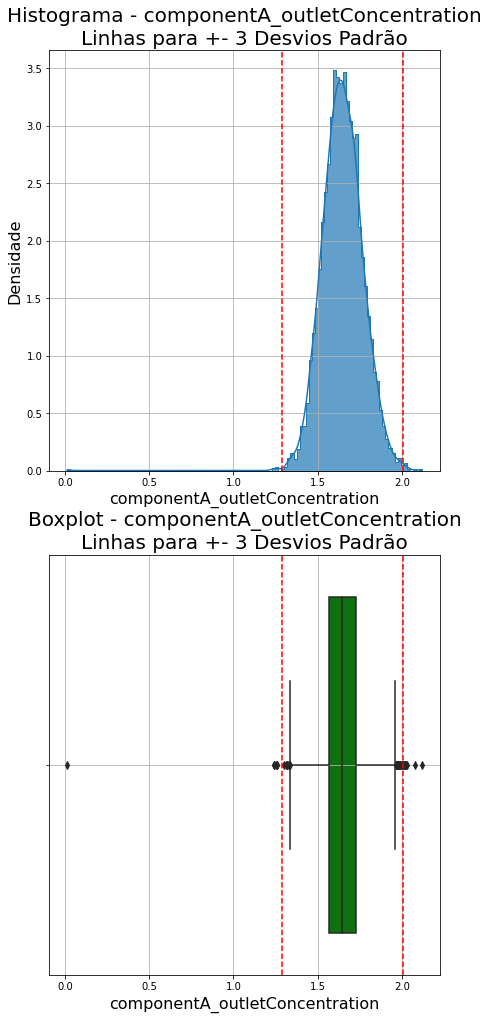

In [ ]:
# construção de histogramas e boxplots
def hist_boxplot(data, var_name):
  # função que cria gráficos de histograma e boxplot para uma variável selecionada
  to_monitor = pd.DataFrame(data[var_name], columns=[var_name])

  # cálculo de parâmetros para construção de linhas verticais
  avg = to_monitor[var_name].mean()
  std = to_monitor[var_name].std()

  x1_vline = avg - 3*std
  x2_vline = avg + 3*std

  # construção do histograma e do boxplot
  plt.figure(figsize=(7,17))
  plt.subplot(2,1,1)
  sns.histplot(to_monitor[var_name], stat = 'density', kde = True, element = 'step', alpha = 0.7)
  plt.axvline(x = x1_vline, color = 'r', linestyle = '--')
  plt.axvline(x = x2_vline, color = 'r', linestyle = '--')
  plt.ylabel('Densidade', fontsize = 16)
  plt.xlabel(var_name, fontsize = 16)
  plt.title('Histograma - ' + var_name + '\nLinhas para +- 3 Desvios Padrão', fontsize = 20)
  plt.grid()
  plt.subplot(2,1,2)
  sns.boxplot(x = to_monitor[var_name], orient = 'h', color = 'g')
  plt.axvline(x = x1_vline, color = 'r', linestyle = '--')
  plt.axvline(x = x2_vline, color = 'r', linestyle = '--')
  plt.xlabel(var_name, fontsize = 16)
  plt.title('Boxplot - ' + var_name+ '\nLinhas para +- 3 Desvios Padrão', fontsize = 20)
  plt.grid()

hist_boxplot(data, var_name)